In [126]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def calculer_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Charger données
df_prices = pd.read_csv('data/wfp_data.csv')
df_exchange = pd.read_csv('data/taux_change_brh.csv')

df_prices['date'] = pd.to_datetime(df_prices['date'])
df_exchange['date'] = pd.to_datetime(df_exchange['date'])

df = pd.merge(df_prices, df_exchange, on='date', how='left')
df['exchange_rate'] = df['exchange_rate'].interpolate()
df = df.dropna(subset=['price', 'exchange_rate'])

In [127]:
annee_courante = df['date'].max().year
date_limite = pd.Timestamp(f'{annee_courante - 10}-01-01')
df_recent = df[df['date'] >= date_limite].copy()

# 2. Features de base
df_recent['month'] = df_recent['date'].dt.month
df_recent['year'] = df_recent['date'].dt.year
df_recent['region_code'] = df_recent['admin1'].astype('category').cat.codes
df_recent['product_code'] = df_recent['commodity'].astype('category').cat.codes

# 3. Features séquentielles: moyenne mobile + lags
df_recent = df_recent.sort_values(['commodity','admin1','date'])

df_recent['price_ma_3'] = df_recent.groupby(['commodity','admin1'])['price'] \
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

df_recent['lag_1'] = df_recent.groupby(['commodity','admin1'])['price'].shift(1)
df_recent['lag_3'] = df_recent.groupby(['commodity','admin1'])['price'].shift(3)

In [128]:
# enlever les premières lignes sans historique de lag
df_recent = df_recent.dropna(subset=['lag_1','lag_3'])

features = [
    'month','year',
    'region_code','product_code',
    'exchange_rate',
    'price_ma_3',
    'lag_1','lag_3'
]

def train_test_split_time(data, horizon=12):
    data = data.sort_values('date')
    train = data.iloc[:-horizon]
    test  = data.iloc[-horizon:]
    return train, test

def entrainer_et_evaluer(data):
    X = data[features]
    y = data['price']

    train, test = train_test_split_time(data, horizon=12)

    X_train, y_train = train[features], train['price']
    X_test, y_test   = test[features],  test['price']

    # Random Forest
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=8,
        random_state=42
    )
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    rf_mae  = mean_absolute_error(y_test, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_mape = calculer_mape(y_test, rf_pred)

    # XGBoost
    xgb = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
           )

    xgb_pred = xgb.predict(X_test)

    xgb_mae  = mean_absolute_error(y_test, xgb_pred)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    xgb_mape = calculer_mape(y_test, xgb_pred)

    if xgb_mae <= rf_mae:
        best_model = xgb
        best_name  = "XGBoost"
    else:
        best_model = rf
        best_name  = "RandomForest"

    metrics = {
        "rf":   {"MAE":rf_mae,  "RMSE":rf_rmse,  "MAPE":rf_mape},
        "xgb":  {"MAE":xgb_mae, "RMSE":xgb_rmse, "MAPE":xgb_mape},
        "best": best_name
    }

    return best_model, metrics, test[['date','price']].assign(
        rf_pred=rf_pred,
        xgb_pred=xgb_pred
    )

In [140]:
def forecast_regressif(modele, data, horizon=6):
    data = data.sort_values('date').copy()
    last_row = data.iloc[-1].copy()

    futur = []
    hist_lag1 = last_row['price']
    hist_lag3_buffer = list(data['price'].tail(3).values)  # pour lag_3 dynamique

    for step in range(1, horizon+1):
        future_date = last_row['date'] + pd.DateOffset(months=step)

        month_f = future_date.month
        year_f  = future_date.year

        exchange_f = last_row['exchange_rate'] * (1.02 ** step)
        lag1_f = hist_lag1

        if len(hist_lag3_buffer) >= 3:
            lag3_f = hist_lag3_buffer[-3]
        else:
            lag3_f = hist_lag3_buffer[0]

        price_ma_3_f = np.mean(hist_lag3_buffer[-3:])

        row_feat = pd.DataFrame([{
            'month': month_f,
            'year': year_f,
            'region_code': last_row['region_code'],
            'product_code': last_row['product_code'],
            'exchange_rate': exchange_f,
            'price_ma_3': price_ma_3_f,
            'lag_1': lag1_f,
            'lag_3': lag3_f
        }])

        pred_price = modele.predict(row_feat)[0]

        futur.append({
            "date": future_date.strftime("%Y-%m"),
            "prix": round(pred_price, 2)
        })

        hist_lag1 = pred_price
        hist_lag3_buffer.append(pred_price)

    return futur


=== Oil (vegetable, imported) / North ===
Best model: XGBoost
RandomForest -> MAE 177.63,RMSE 209.58, MAPE 13.81%
XGBoost      -> MAE 126.96,RMSE 154.05, MAPE 9.91%
Prévision 6 mois: [{'date': '2025-07', 'prix': 1528.2}, {'date': '2025-08', 'prix': 1458.34}, {'date': '2025-09', 'prix': 1519.77}, {'date': '2025-10', 'prix': 1584.41}, {'date': '2025-11', 'prix': 1578.48}, {'date': '2025-12', 'prix': 1576.01}]


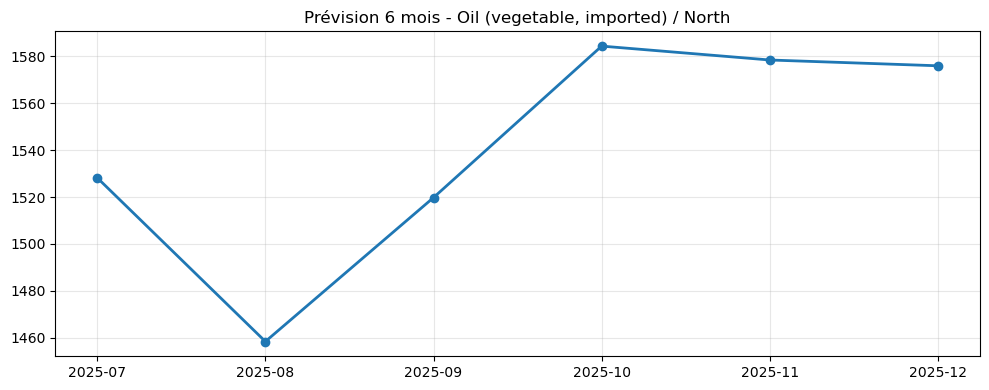

In [144]:

products = ['Oil (vegetable, imported)']
regions  = ['North']

resultats = []
for prod in products:
    for reg in regions:
        subset = df_recent[(df_recent['commodity']==prod) & (df_recent['admin1']==reg)].copy()
        if len(subset) < 24:
            continue

        best_model, mets, eval_block = entrainer_et_evaluer(subset)
        fut = forecast_regressif(best_model, subset, horizon=6)

        print(f"\n=== {prod} / {reg} ===")
        print(f"Best model: {mets['best']}")
        print(f"RandomForest -> MAE {mets['rf']['MAE']:.2f},RMSE {mets['rf']['RMSE']:.2f}, MAPE {mets['rf']['MAPE']:.2f}%")
        print(f"XGBoost      -> MAE {mets['xgb']['MAE']:.2f},RMSE {mets['xgb']['RMSE']:.2f}, MAPE {mets['xgb']['MAPE']:.2f}%")
        print("Prévision 6 mois:", fut)


        plt.figure(figsize=(10,4))
        plt.plot([p['date'] for p in fut], [p['prix'] for p in fut],
                 marker='o', linewidth=2)
        plt.title(f"Prévision 6 mois - {prod} / {reg}")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()